# Description

This notebook explores a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait's gene associations (gene p-values).
Since predicted gene expression is correlated among closeby genes, a simple OLS model is expected to fail by having high type I errors in some LVs.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis
from phenoplier_plots import qqplot

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "1000g_eur"
    / "no_covars"
    / "_corrs_all"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)
assert INPUT_DIR.exists()

PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results):
    lv_code = None
    lvs = results["lv"].unique()
    if lvs.shape[0] == 1:
        lv_code = lvs[0]

    traits = results["phenotype"].unique()

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = qqplot(results[PVALUE_COLUMN])
        if lvs.shape[0] == 1:
            ax.set_title(f"{lv_code} - {traits.shape[0]} traits")
        else:
            ax.set_title(f"{lvs.shape[0]} LVs - {traits.shape[0]} traits")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/1000g_eur/no_covars/_corrs_all/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV136,0.395557,0.124577,3.175197,0.001504,0.000752,random.pheno988
1,LV816,0.329201,0.124607,2.641912,0.008264,0.004132,random.pheno988
2,LV175,0.328595,0.124608,2.637044,0.008383,0.004192,random.pheno988
3,LV585,0.318081,0.124612,2.552578,0.010716,0.005358,random.pheno988
4,LV815,0.312077,0.124614,2.504350,0.012292,0.006146,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.0582887537993921

# QQ-plot

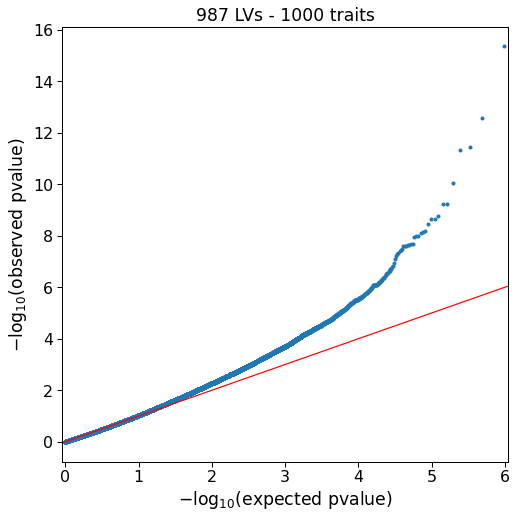

In [18]:
qqplot_unif(dfs)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.007,0.025,0.069
1,LV10,0.012,0.039,0.080
2,LV100,0.015,0.052,0.084
3,LV101,0.016,0.037,0.088
4,LV102,0.013,0.056,0.083


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016040,0.058289,0.105322
std,0.006493,0.014076,0.019832
min,0.001000,0.015000,0.055000
25%,0.012000,0.049000,0.092000
50%,0.016000,0.058000,0.105000
75%,0.019000,0.067000,0.118000
max,0.071000,0.135000,0.192000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(83, 4)

,lv,1,5,10
180,LV261,0.013,0.049,0.085
422,LV48,0.008,0.049,0.094
418,LV476,0.014,0.049,0.092
477,LV529,0.016,0.049,0.084
821,LV839,0.017,0.049,0.089
386,LV447,0.011,0.049,0.094
374,LV436,0.015,0.049,0.092
880,LV892,0.014,0.049,0.097
507,LV556,0.014,0.049,0.096
895,LV905,0.016,0.049,0.092


,lv,1,5,10
24,LV120,0.016,0.051,0.092
68,LV160,0.009,0.051,0.102
70,LV162,0.013,0.051,0.087
90,LV180,0.019,0.051,0.113
125,LV211,0.010,0.051,0.107
149,LV233,0.008,0.051,0.091
257,LV330,0.010,0.051,0.098
700,LV73,0.014,0.051,0.090
299,LV369,0.008,0.051,0.085
311,LV38,0.017,0.051,0.103


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(407, 4)

,lv,1,5,10
542,LV588,0.017,0.089,0.153
946,LV951,0.027,0.089,0.156
151,LV235,0.029,0.090,0.132
341,LV406,0.021,0.090,0.139
632,LV669,0.024,0.093,0.156
501,LV550,0.034,0.093,0.149
672,LV704,0.022,0.095,0.158
417,LV475,0.030,0.095,0.166
707,LV736,0.026,0.096,0.158
904,LV913,0.031,0.098,0.141


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
922,LV45,-0.189880,0.124652,-1.523281,0.127738,0.936131,random.pheno988
1321,LV45,0.042006,0.124674,0.336931,0.736180,0.368090,random.pheno589
2182,LV45,0.096388,0.124669,0.773151,0.439461,0.219731,random.pheno385
3477,LV45,-0.012014,0.124675,-0.096362,0.923236,0.538382,random.pheno5
4362,LV45,0.016350,0.124675,0.131144,0.895665,0.447833,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.064

In [32]:
show_prop(results, 0.05)

0.135

In [33]:
show_prop(results, 0.10)

0.187

In [34]:
show_prop(results, 0.15)

0.23

In [35]:
show_prop(results, 0.20)

0.272

### QQplot

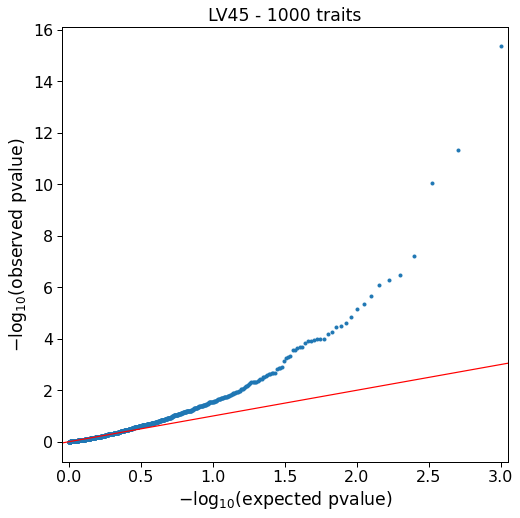

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
652,LV234,-0.062891,0.124672,-0.504451,0.613962,0.693019,random.pheno988
1795,LV234,-0.123671,0.124665,-0.992027,0.321222,0.839389,random.pheno589
2800,LV234,-0.119418,0.124666,-0.957906,0.338146,0.830927,random.pheno385
3559,LV234,-0.034959,0.124674,-0.280405,0.779176,0.610412,random.pheno5
4206,LV234,0.075490,0.124671,0.605516,0.544857,0.272429,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.071

In [43]:
show_prop(results, 0.05)

0.128

In [44]:
show_prop(results, 0.10)

0.162

In [45]:
show_prop(results, 0.15)

0.199

In [46]:
show_prop(results, 0.20)

0.232

### QQplot

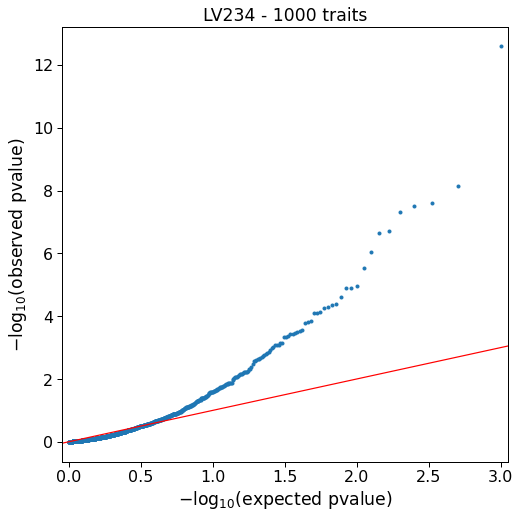

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
421,LV847,0.002137,0.124675,0.017137,0.986328,0.493164,random.pheno988
1459,LV847,-0.008561,0.124675,-0.068665,0.945259,0.527371,random.pheno589
2656,LV847,-0.067522,0.124672,-0.541598,0.588114,0.705943,random.pheno385
3410,LV847,0.008248,0.124675,0.066152,0.947259,0.473629,random.pheno5
4315,LV847,0.029868,0.124674,0.239567,0.810674,0.405337,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.068

In [54]:
show_prop(results, 0.05)

0.133

In [55]:
show_prop(results, 0.10)

0.177

In [56]:
show_prop(results, 0.15)

0.224

In [57]:
show_prop(results, 0.20)

0.267

### QQplot

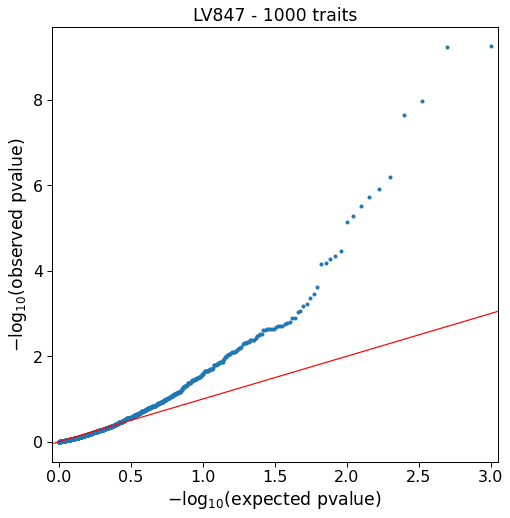

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
956,LV110,-0.235891,0.124640,-1.892578,0.058459,0.970771,random.pheno988
1638,LV110,-0.065987,0.124672,-0.529282,0.596628,0.701686,random.pheno589
2693,LV110,-0.080320,0.124671,-0.644255,0.519433,0.740284,random.pheno385
3498,LV110,-0.019405,0.124675,-0.155645,0.876318,0.561841,random.pheno5
4907,LV110,-0.220342,0.124645,-1.767764,0.077148,0.961426,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.049

In [65]:
show_prop(results, 0.05)

0.105

In [66]:
show_prop(results, 0.10)

0.15

In [67]:
show_prop(results, 0.15)

0.19

In [68]:
show_prop(results, 0.20)

0.225

### QQplot

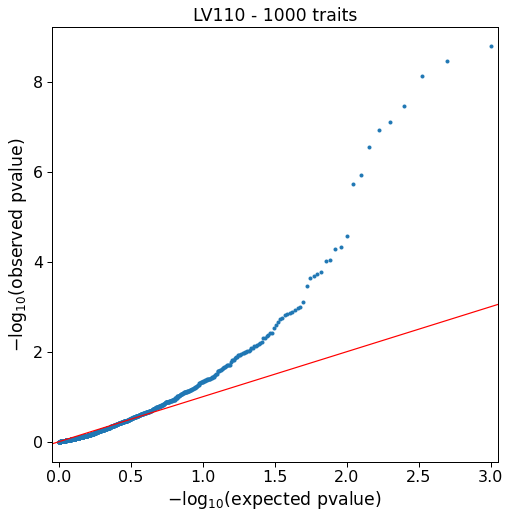

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
235,LV769,0.076397,0.124671,0.612787,0.540039,0.270019,random.pheno988
1304,LV769,0.049869,0.124673,0.399999,0.689170,0.344585,random.pheno589
2517,LV769,-0.021888,0.124674,-0.175559,0.860646,0.569677,random.pheno385
3876,LV769,-0.165544,0.124658,-1.327986,0.184230,0.907885,random.pheno5
4915,LV769,-0.236700,0.124640,-1.899070,0.057600,0.971200,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.023

In [76]:
show_prop(results, 0.05)

0.074

In [77]:
show_prop(results, 0.10)

0.136

In [78]:
show_prop(results, 0.15)

0.182

In [79]:
show_prop(results, 0.20)

0.239

### QQplot

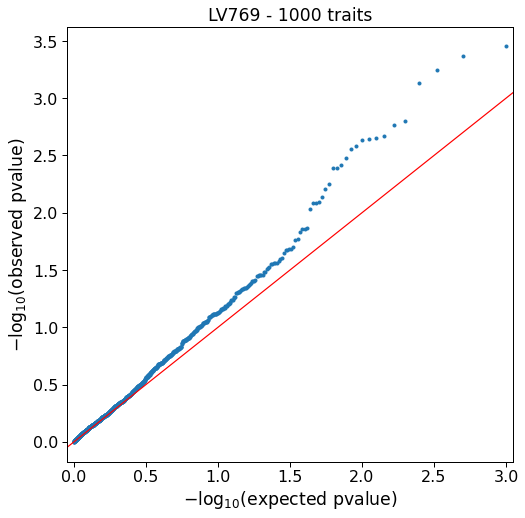

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
91,LV800,0.156470,0.124660,1.255176,0.209460,0.104730,random.pheno988
1338,LV800,0.035482,0.124674,0.284599,0.775960,0.387980,random.pheno589
2839,LV800,-0.135644,0.124663,-1.088081,0.276600,0.861700,random.pheno385
3841,LV800,-0.146772,0.124661,-1.177369,0.239092,0.880454,random.pheno5
4608,LV800,-0.061892,0.124672,-0.496437,0.619603,0.690198,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.056

In [87]:
show_prop(results, 0.05)

0.126

In [88]:
show_prop(results, 0.10)

0.178

In [89]:
show_prop(results, 0.15)

0.223

In [90]:
show_prop(results, 0.20)

0.264

### QQplot

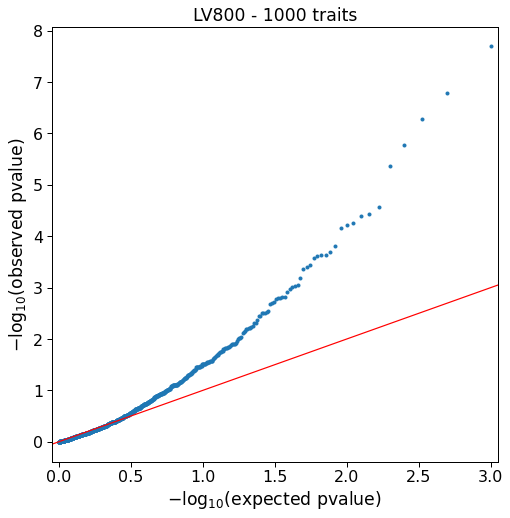

In [91]:
qqplot_unif(results)

## LV806

In [92]:
lv_code = "LV806"

In [93]:
results = dfs[dfs["lv"] == lv_code]

In [94]:
results.shape

(1000, 7)

In [95]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
775,LV806,-0.103149,0.124668,-0.827389,0.408047,0.795976,random.pheno988
1335,LV806,0.037101,0.124674,0.297588,0.766028,0.383014,random.pheno589
2081,LV806,0.153098,0.124660,1.228121,0.219447,0.109723,random.pheno385
3732,LV806,-0.095087,0.124669,-0.762717,0.445660,0.777170,random.pheno5
4286,LV806,0.042581,0.124674,0.341540,0.732708,0.366354,random.pheno74


In [96]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [97]:
show_prop(results, 0.01)

0.013

In [98]:
show_prop(results, 0.05)

0.05

In [99]:
show_prop(results, 0.10)

0.089

In [100]:
show_prop(results, 0.15)

0.122

In [101]:
show_prop(results, 0.20)

0.171

### QQplot

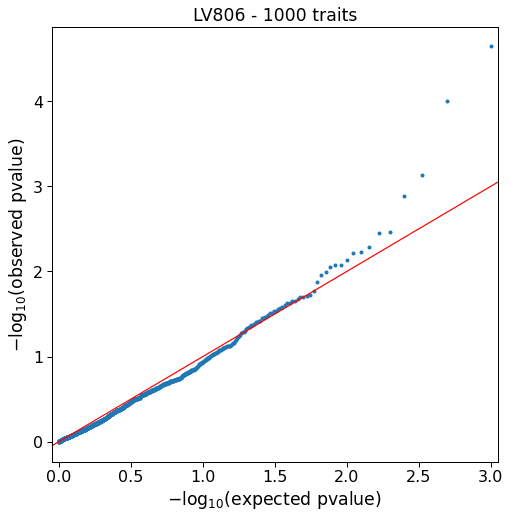

In [102]:
qqplot_unif(results)

# LVs with expected mean type I error

In [103]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
180,LV261,0.013,0.049,0.085
422,LV48,0.008,0.049,0.094
418,LV476,0.014,0.049,0.092
477,LV529,0.016,0.049,0.084
821,LV839,0.017,0.049,0.089
386,LV447,0.011,0.049,0.094
374,LV436,0.015,0.049,0.092
880,LV892,0.014,0.049,0.097
507,LV556,0.014,0.049,0.096
895,LV905,0.016,0.049,0.092


In [104]:
lv_results_expected = {}

## LV412

In [105]:
lv_code = "LV412"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
636,LV412,-0.058952,0.124673,-0.472854,0.636333,0.681833,random.pheno988
1709,LV412,-0.094120,0.124669,-0.754958,0.450302,0.774849,random.pheno589
2015,LV412,0.229939,0.124642,1.844796,0.065113,0.032557,random.pheno385
3161,LV412,0.102204,0.124668,0.819807,0.412357,0.206178,random.pheno5
4028,LV412,0.174124,0.124656,1.396834,0.162512,0.081256,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.015

In [111]:
show_prop(results, 0.05)

0.043

In [112]:
show_prop(results, 0.10)

0.087

In [113]:
show_prop(results, 0.15)

0.125

In [114]:
show_prop(results, 0.20)

0.179

### QQplot

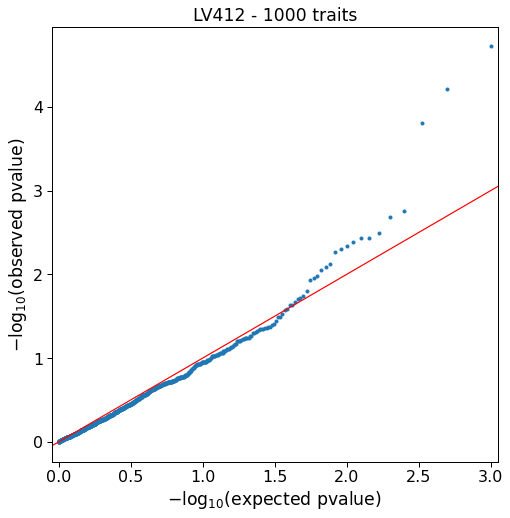

In [115]:
qqplot_unif(results)

## LV57

In [116]:
lv_code = "LV57"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
664,LV57,-0.068391,0.124672,-0.548572,0.583318,0.708341,random.pheno988
1148,LV57,0.116952,0.124666,0.938123,0.348216,0.174108,random.pheno589
2125,LV57,0.124203,0.124665,0.996294,0.319145,0.159572,random.pheno385
3528,LV57,-0.029068,0.124674,-0.233153,0.815650,0.592175,random.pheno5
4244,LV57,0.057677,0.124673,0.462626,0.643648,0.321824,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.015

In [122]:
show_prop(results, 0.05)

0.048

In [123]:
show_prop(results, 0.10)

0.098

In [124]:
show_prop(results, 0.15)

0.142

In [125]:
show_prop(results, 0.20)

0.174

### QQplot

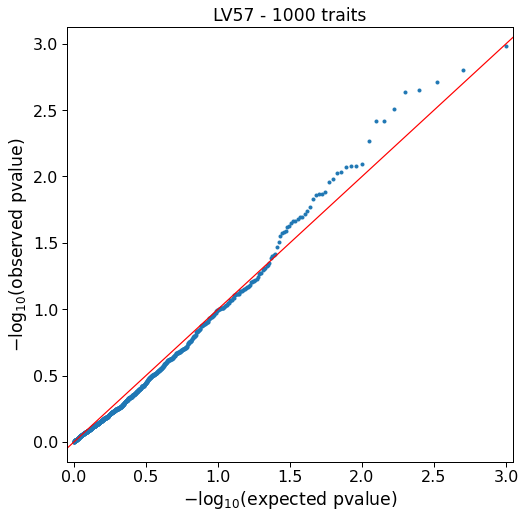

In [126]:
qqplot_unif(results)

## LV647

In [127]:
lv_code = "LV647"

In [128]:
results = dfs[dfs["lv"] == lv_code]

In [129]:
results.shape

(1000, 7)

In [130]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
744,LV647,-0.092518,0.124669,-0.742103,0.458052,0.770974,random.pheno988
1472,LV647,-0.010725,0.124675,-0.086027,0.931448,0.534276,random.pheno589
2629,LV647,-0.059222,0.124673,-0.475020,0.634789,0.682606,random.pheno385
3119,LV647,0.123317,0.124665,0.989187,0.322609,0.161304,random.pheno5
4648,LV647,-0.075208,0.124671,-0.603253,0.546361,0.726819,random.pheno74


In [131]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [132]:
show_prop(results, 0.01)

0.013

In [133]:
show_prop(results, 0.05)

0.05

In [134]:
show_prop(results, 0.10)

0.093

In [135]:
show_prop(results, 0.15)

0.145

In [136]:
show_prop(results, 0.20)

0.192

### QQplot

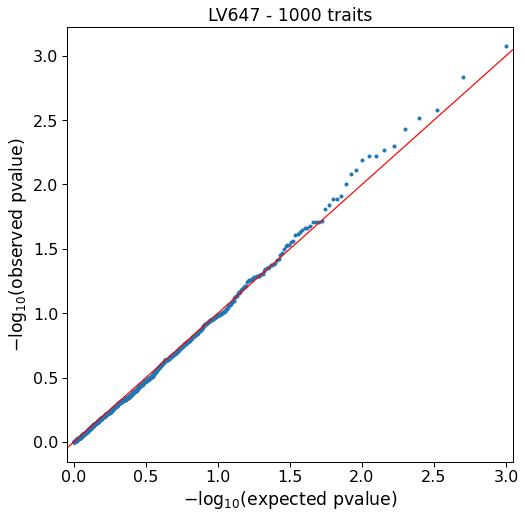

In [137]:
qqplot_unif(results)